In [1]:
# import and dataset loading
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score, classification_report, roc_curve, auc
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, homogeneity_completeness_v_measure
from kneed import KneeLocator

dataset = pd.read_csv("example_dataset.csv")


In [2]:
#ElMo embeddings
import tensorflow_hub as hub
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()
# Load pre trained ELMo model
elmo = hub.Module("https://tfhub.dev/google/elmo/3")
embedded = elmo(dataset['no_dots'], signature="default", as_dict=True)
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
embeddings = sess.run(embedded['default'])

2023-05-03 18:31:18.618059: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-03 18:31:18.827978: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-03 18:31:18.827995: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-05-03 18:31:18.852464: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-05-03 18:31:19.426931: W tensorflow/stream_executor/platform/de

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
2023-05-03 18:32:06.896981: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2023-05-03 18:32:06.897060: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: lorenzo-Legion-5-Pro-16ARH7H
2023-05-03 18:32:06.897075: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: lorenzo-Legion-5-Pro-16ARH7H
2023-05-03 18:32:06.897436: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.86.1
2023-05-03 18:32:06.897481: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.86.1
2023-05-03 18:32:06.897491: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 515.86.1
2023-05-03 18:32:06.898428: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow bina

In [3]:
# transform embeddings in dataframe
embeddings_df = pd.DataFrame(embeddings)
print(embeddings_df)

          0         1         2         3         4         5         6      
0    -0.383453  0.237976  0.325692  0.256787  0.769068 -0.589895 -0.095655  \
1     0.382978  0.039677  0.520147  0.359138  0.387891 -0.148101  0.161554   
2     0.198299  0.045792  0.494703  0.087017  0.032744 -0.189313  0.177954   
3     0.279804  0.083523  0.257729  0.087128  0.508410 -0.327920  0.363263   
4     0.268821 -0.403296  0.023097 -0.115428  0.150471  0.128927  0.285498   
...        ...       ...       ...       ...       ...       ...       ...   
9995 -0.092584  0.255573  0.146999  0.100070 -0.152107 -0.428068  0.117171   
9996 -0.185229  0.283645 -0.286042  0.478192 -0.095291 -0.251398  0.380394   
9997 -0.112391  0.469710 -0.072027 -0.120044  0.090967 -0.315929  0.035310   
9998  0.129397  0.029462 -0.400044  0.355933 -0.103662 -0.194286  0.295104   
9999  0.085365  0.215580  0.041698 -0.012625 -0.100071 -0.408339  0.146808   

          7         8         9     ...      1014      1015    

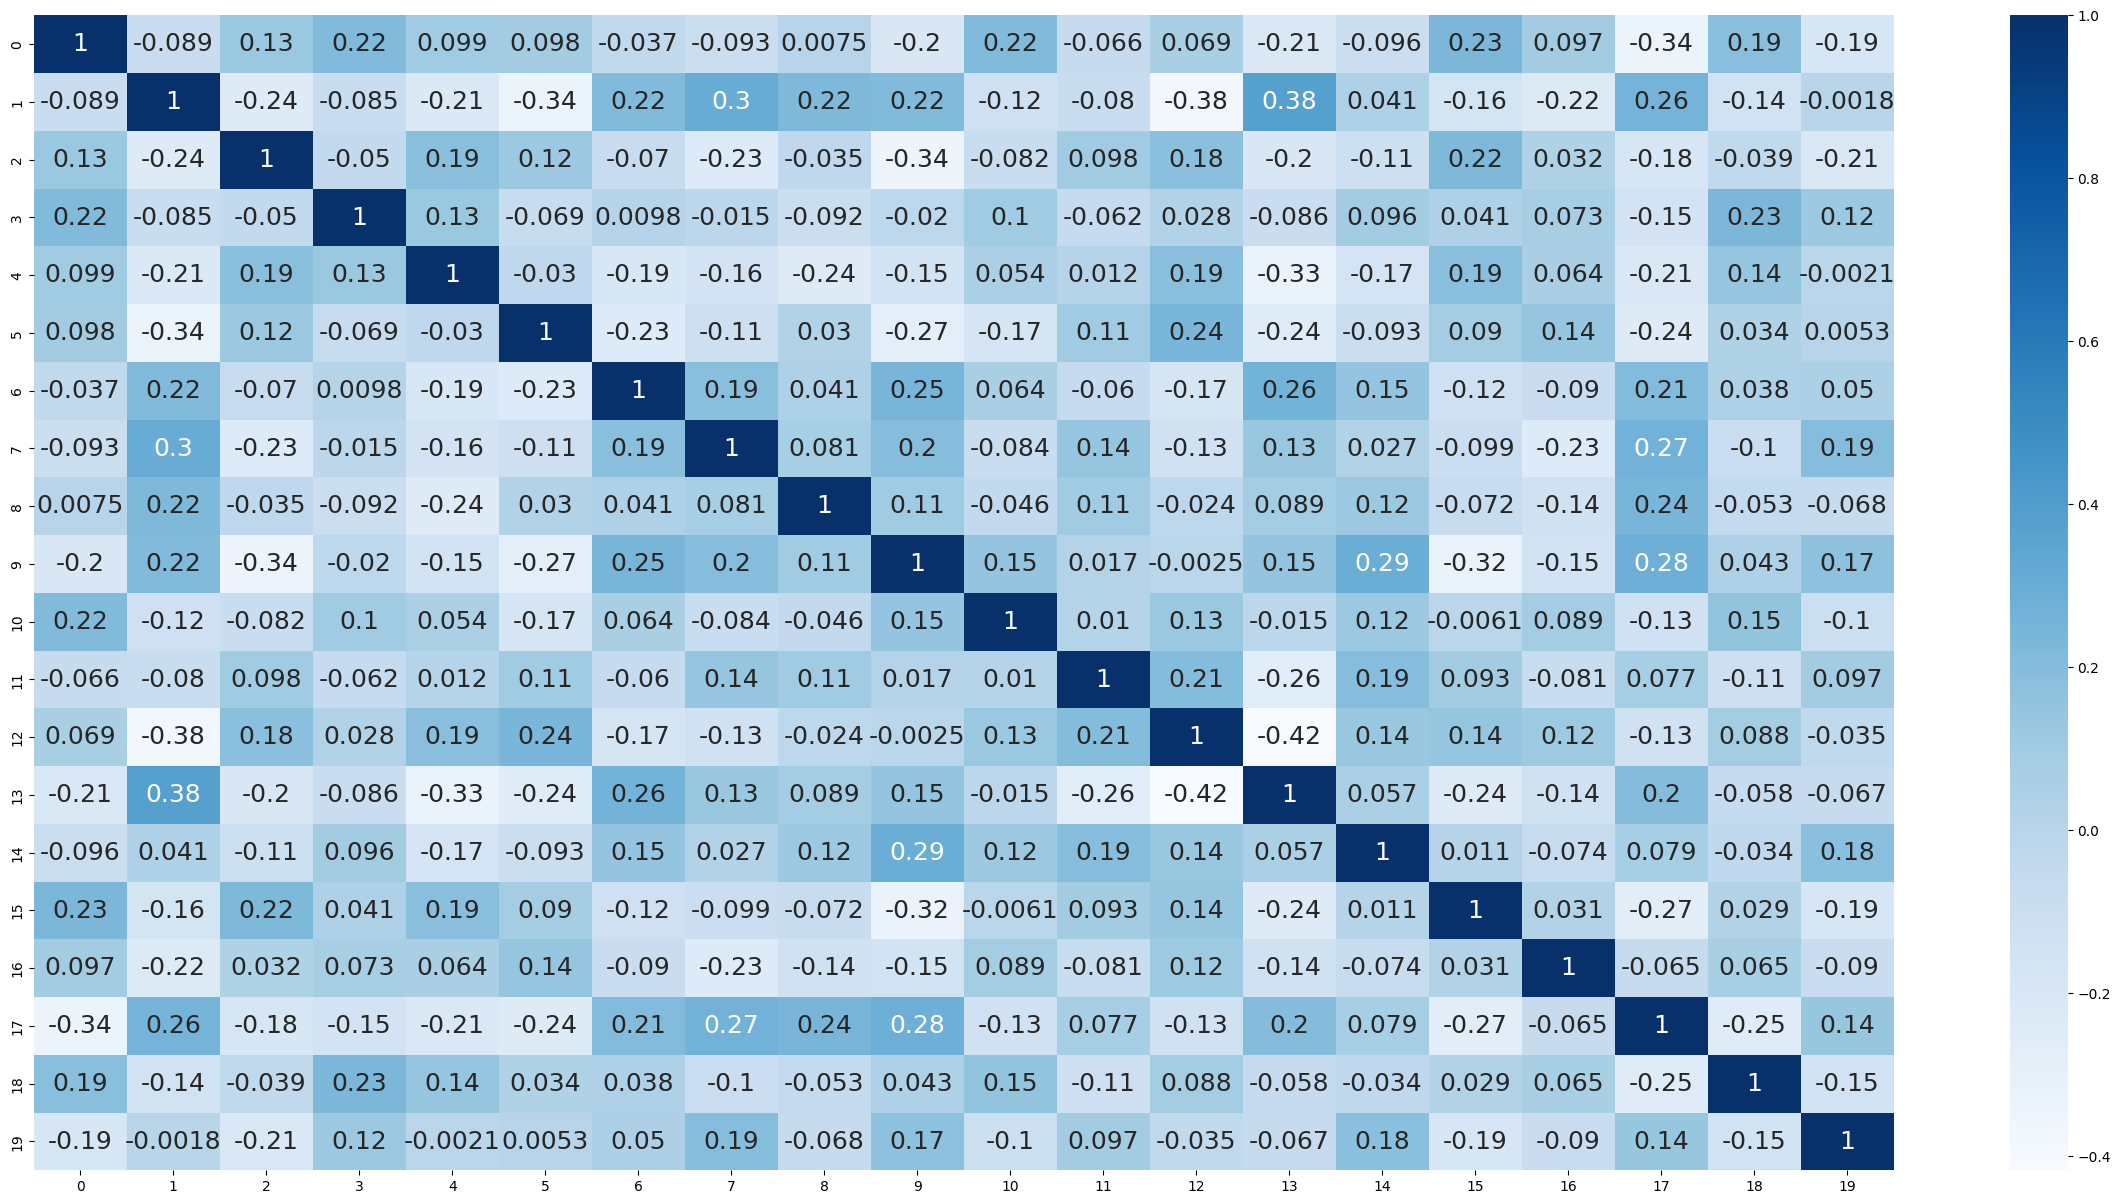

In [4]:
plt.figure(figsize=(30,15))
ax = sns.heatmap(embeddings_df[embeddings_df.columns[0:20]].corr(),cmap="Blues",annot=True,annot_kws={"size": 18})

In [36]:
#Lettura dati ed embedding
labels_for_split = dataset.loc[:,['label']]
#random state per test con lo stesso split ogni volta
train, test, label_train, label_test=train_test_split(embeddings_df, labels_for_split, test_size=0.1, random_state=30)
print(train.shape)
print(test.shape)
print(label_train.shape)
print(label_test.shape)

(9000, 1024)
(1000, 1024)
(9000, 1)
(1000, 1)


In [37]:
# setting altri parametri per la classificazione
kfold = StratifiedKFold(n_splits=5)
cross_validation_scores = [] # punteggi della cross validation
classification_reports = []
confusion_matrices = []
roc_aucs = [] #roc curve:
true_pos_rates = []
false_pos_rates = []
pred_for_correlation = pd.DataFrame.copy(label_test)
#preparazione classificatori
names=["SVC", "KNN", "Naive Bayes", "Decision Tree", "Random Forest", "AdaBoost", "Gradient Boosting", "MLP"]
classifiers=[ SVC(), KNeighborsClassifier(n_neighbors=5), GaussianNB(), DecisionTreeClassifier(),
              RandomForestClassifier(n_estimators=10), AdaBoostClassifier(n_estimators=10), 
              GradientBoostingClassifier(n_estimators=10), MLPClassifier()]

"""
POSSIBILI PARAM DA GESTIRE SECONDO ME

SVC
Testare altri kernel? per ora default, rbf, ovvero esponenziale

KNN
default n_neighbors=5

ALBERO
criterion{“gini”, “entropy”, “log_loss”}, default=”gini”
max_depth int, default=None
max_features int, float or {“auto”, “sqrt”, “log2”}, default=None
    (The number of features to consider when looking for the best split)
min_samples_split int or float, default=2
    (The minimum number of samples required to split an internal node)

Per avere sempre gli stessi risultati:
random_state int, RandomState instance or None, default=None 
    (The features are always randomly permuted at each split, even if splitter is set to "best")
    
RANDOM FOREST
n_estimators int, default=100
criterion{“gini”, “entropy”, “log_loss”}, default=”gini”
max_depth int, default=None
max_features{“sqrt”, “log2”, None}, int or float, default=”sqrt”. Funzione del numero di feature.
    (The number of features to consider when looking for the best split)
min_samples_split int or float, default=2
    (The minimum number of samples required to split an internal node)
    
Per avere sempre gli stessi risultati uguale agli alberi

ADABOOST
default stimatori è 50
learning_rate: float, default=1.0

GRADIENT BOOSTING
default stimatori (alberi) è 100
learning rate default=0.1
parametri analoghi agli alberi

MLP
hidden_layer_sizes
solver{‘lbfgs’, ‘sgd’, ‘adam’}, default=’adam’ (dicono che lbfgs tende ad essere meglio con dataset piccoli, non so
come conta il nostro)
batch_size:int, default=’auto’
"""
print(dict(zip(names,classifiers)).items())

dict_items([('SVC', SVC()), ('KNN', KNeighborsClassifier()), ('Naive Bayes', GaussianNB()), ('Decision Tree', DecisionTreeClassifier()), ('Random Forest', RandomForestClassifier(n_estimators=10)), ('AdaBoost', AdaBoostClassifier(n_estimators=10)), ('Gradient Boosting', GradientBoostingClassifier(n_estimators=10)), ('MLP', MLPClassifier())])


In [10]:
#train e test dei classificatori:
for name, classif in zip(names,classifiers):
    # fitting model and make predictions
    classif.fit(train, label_train)
    predictions = classif.predict(test)
    pred_for_correlation[name] = predictions
    print(f"{name}. Accuracy: {accuracy_score(label_test, predictions)}")
    # cross-validation
    cv_score = cross_val_score(classif, train, label_train, scoring = "accuracy",cv = kfold)
    cross_validation_scores.append(cv_score)
    print("Done K-Fold cross-validation")
    # confusion matrix
    cf = confusion_matrix(label_test, predictions)
    confusion_matrices.append(cf)
    print("Computed confusion matrix")
    # classification report
    class_report = classification_report(label_test, predictions)
    classification_reports.append(class_report)
    print("Done classification report")
    # roc_curve
    fpr, tpr, _ = roc_curve(predictions, label_test)
    roc_aucs.append(auc(fpr, tpr))
    true_pos_rates.append(tpr)
    false_pos_rates.append(fpr)
    print("computed ROC curve paramaters")
    print()

SVC. Accuracy: 0.938
Done K-Fold cross-validation
Computed confusion matrix
Done classification report
computed ROC curve paramaters

KNN. Accuracy: 0.84
Done K-Fold cross-validation
Computed confusion matrix
Done classification report
computed ROC curve paramaters

Naive Bayes. Accuracy: 0.84
Done K-Fold cross-validation
Computed confusion matrix
Done classification report
computed ROC curve paramaters

Decision Tree. Accuracy: 0.8
Done K-Fold cross-validation
Computed confusion matrix
Done classification report
computed ROC curve paramaters

Random Forest. Accuracy: 0.861
Done K-Fold cross-validation
Computed confusion matrix
Done classification report
computed ROC curve paramaters

AdaBoost. Accuracy: 0.844
Done K-Fold cross-validation
Computed confusion matrix
Done classification report
computed ROC curve paramaters

Gradient Boosting. Accuracy: 0.831
Done K-Fold cross-validation
Computed confusion matrix
Done classification report
computed ROC curve paramaters

MLP. Accuracy: 0.93

8 8 8
   CrossValMeans  CrossValerrors          Algorithm
0       0.935889        0.004076                SVC
1       0.834667        0.004901                KNN
2       0.845222        0.004589        Naive Bayes
3       0.789556        0.010143      Decision Tree
4       0.846000        0.008912      Random Forest
5       0.846222        0.009002           AdaBoost
6       0.848778        0.011871  Gradient Boosting
7       0.929444        0.003083                MLP


Text(0.5, 1.0, 'Cross validation scores')

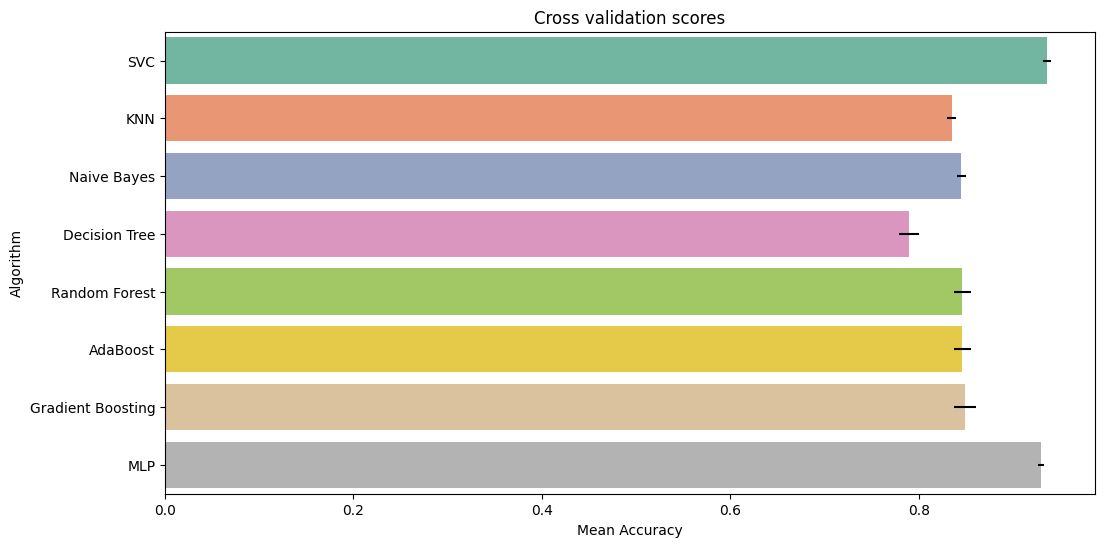

In [11]:
cross_val_mean_acc = [] # accuretezza media della cross validation
cross_val_std = [] # deviazione standard della cross validation
# cross validation plot
for i in cross_validation_scores:
    cross_val_mean_acc.append(i.mean())
    cross_val_std.append(i.std())
print(len(cross_val_mean_acc), len(cross_val_std), len(names))
cv_df = pd.DataFrame({"CrossValMeans":cross_val_mean_acc, "CrossValerrors": cross_val_std,"Algorithm":names})
print(cv_df)
plt.figure(figsize=(12,6))
sns.barplot(x="CrossValMeans",y="Algorithm", data=cv_df, palette="Set2",orient = "h", **{'xerr':cross_val_std})
plt.xlabel("Mean Accuracy")
plt.title("Cross validation scores")

In [12]:
# normalizzazione matrici di confusione
confusion_matrices_2 = np.zeros(shape=np.array(confusion_matrices).shape)
for i in range(len(confusion_matrices)):
    for j in range(len(confusion_matrices[i])):
        tot = sum(confusion_matrices[i][j])
        for k in range(len(confusion_matrices[i][j])):
            confusion_matrices_2[i][j][k] = confusion_matrices[i][j][k]/tot
print(confusion_matrices_2)
        

[[[0.94664032 0.05335968]
  [0.0708502  0.9291498 ]]

 [[0.72529644 0.27470356]
  [0.04251012 0.95748988]]

 [[0.95652174 0.04347826]
  [0.27935223 0.72064777]]

 [[0.80039526 0.19960474]
  [0.20040486 0.79959514]]

 [[0.93083004 0.06916996]
  [0.21052632 0.78947368]]

 [[0.85375494 0.14624506]
  [0.1659919  0.8340081 ]]

 [[0.8715415  0.1284585 ]
  [0.21052632 0.78947368]]

 [[0.93675889 0.06324111]
  [0.05870445 0.94129555]]]


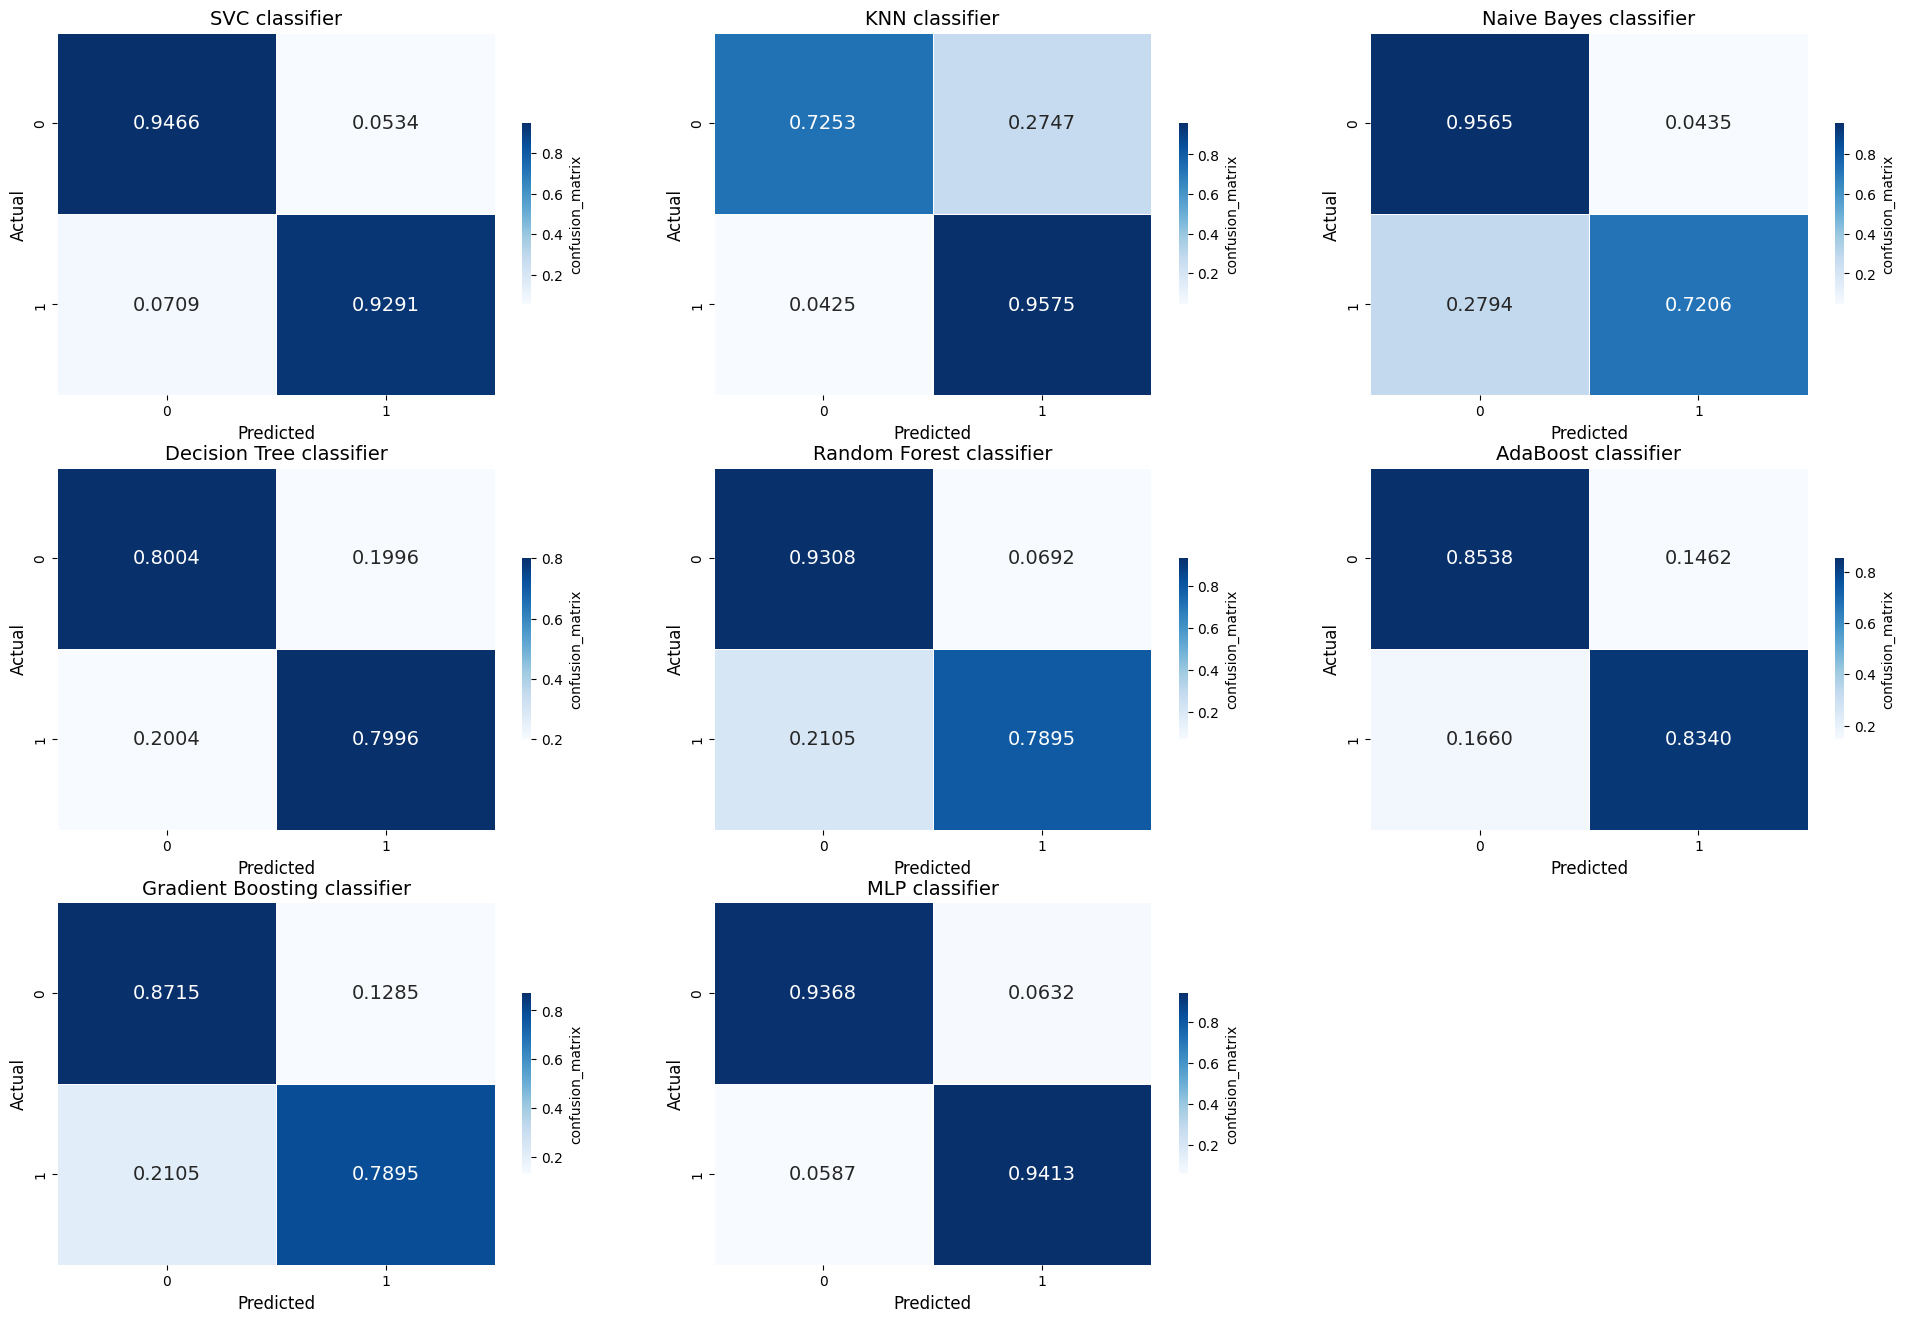

In [19]:
# Matrici di confusione
plt.figure(figsize=(30,25))
for i in range(len(names)):
    plt.subplot(3,3, i+1)
    sns.heatmap(confusion_matrices_2[i], annot=True, linewidths=.5, fmt=".4f", cmap='Blues', annot_kws={"size": 14},
                cbar_kws={"shrink": 0.5, "label": f"confusion_matrix"}, xticklabels=True, yticklabels=True)
    figure = plt.gcf()
    figure.set_size_inches(24, 16)
    plt.xticks(rotation=0, fontsize=10)
    plt.yticks(fontsize=10)
    plt.xlabel("Predicted", fontsize=12)
    plt.ylabel("Actual", fontsize=12)
    plt.title(f"{names[i]} classifier", fontsize=14)

In [20]:
#Classification reports
for i in range(len(names)):
    print (f"{names[i]} Classification Report:" );
    print (classification_reports[i]);

SVC Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       506
           1       0.94      0.93      0.94       494

    accuracy                           0.94      1000
   macro avg       0.94      0.94      0.94      1000
weighted avg       0.94      0.94      0.94      1000

KNN Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.73      0.82       506
           1       0.77      0.96      0.86       494

    accuracy                           0.84      1000
   macro avg       0.86      0.84      0.84      1000
weighted avg       0.86      0.84      0.84      1000

Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.96      0.86       506
           1       0.94      0.72      0.82       494

    accuracy                           0.84      1000
   macro avg       0.86      0.84      

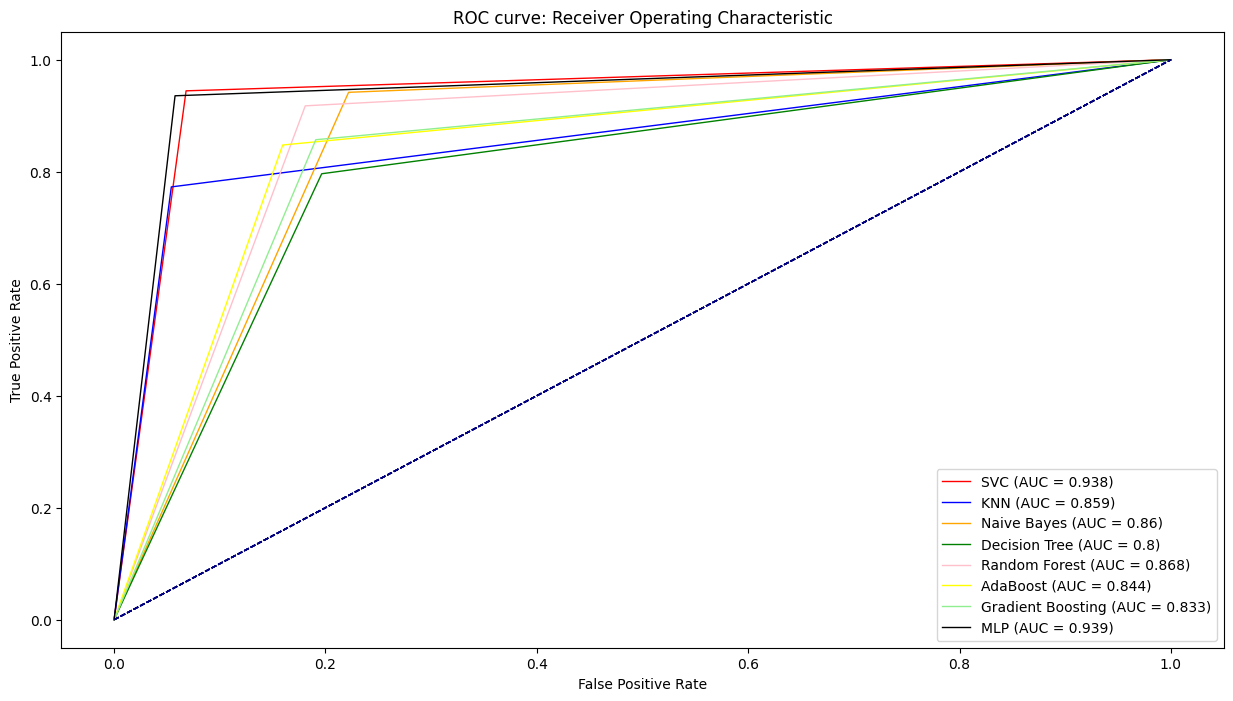

In [21]:
plt.figure(figsize=(15,8))
for i in range(len(names)):
    cm = ['red', 'blue', 'orange', 'green', 'pink', 'yellow', 'lightgreen', 'black', 'purple', 'lightblue'] #add more colours for more algorithms
    plt.plot(false_pos_rates[i], true_pos_rates[i], c=cm[i], lw=1, 
             label=f"{names[i]} (AUC = {round(roc_aucs[i],3)})")
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve: Receiver Operating Characteristic')
    plt.legend(loc="lower right")

8793                                                                 1
1122                                                                 0
1283                                                                 0
9318                                                                 1
7765                                                                 1
                                           ...                        
Decision Tree        [1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, ...
Random Forest        [1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, ...
AdaBoost             [1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, ...
Gradient Boosting    [1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, ...
MLP                  [1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, ...
Name: label, Length: 1008, dtype: object


ValueError: No axis named 1 for object type Series

<Figure size 1500x800 with 0 Axes>